<a href="https://www.kaggle.com/code/sreenihaar/maincode?scriptVersionId=235896142" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Concatenate, MultiHeadAttention, Add, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
from nltk.sentiment import SentimentIntensityAnalyzer
import textstat


# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

2025-04-24 15:57:03.063703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745510223.305621      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745510223.374456      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/n

True

In [3]:
datasets_path='/kaggle/input/dataset/'

In [4]:
# Load original datasets
# data_path = '/home/purview-x/Downloads/sproject/fake_news_prediction'
data_path=datasets_path+'fake_news_prediction'
true_df = pd.read_csv(f'{data_path}/Data-1/True.csv')
fake_df = pd.read_csv(f'{data_path}/Data-1/Fake.csv')

# Assign labels
true_df['label'] = 1  # Real news
fake_df['label'] = 0  # Fake news

# Load new datasets
# new_data_path = '/home/purview-x/Downloads/sproject/newnews'
new_data_path = datasets_path+'newnews'
real1_df = pd.read_csv(f'{new_data_path}/real1.csv')
fake1_df = pd.read_csv(f'{new_data_path}/fake1.csv')

# Assign labels to new datasets
real1_df['label'] = 1  # Real news
fake1_df['label'] = 0  # Fake news

# Print column information to understand structure
print("Original true_df columns:", true_df.columns.tolist())
print("Original fake_df columns:", fake_df.columns.tolist())
print("New real1_df columns:", real1_df.columns.tolist())
print("New fake1_df columns:", fake1_df.columns.tolist())

Original true_df columns: ['title', 'text', 'subject', 'date', 'label']
Original fake_df columns: ['title', 'text', 'subject', 'date', 'label']
New real1_df columns: ['id', 'title', 'text', 'url', 'top_img', 'authors', 'source', 'publish_date', 'movies', 'images', 'canonical_link', 'meta_data', 'label']
New fake1_df columns: ['id', 'title', 'text', 'url', 'top_img', 'authors', 'source', 'publish_date', 'movies', 'images', 'canonical_link', 'meta_data', 'label']


In [5]:
# Function to clean and standardize dataframes
def clean_and_standardize(df):
    # Remove rows with missing title or text
    df = df.dropna(subset=['title', 'text'])

    # Basic text cleaning
    df['title'] = df['title'].str.strip()
    df['text'] = df['text'].str.strip()

    # Select only needed columns (match original dataset structure)
    needed_columns = ['title', 'text', 'label']
    existing_columns = [col for col in needed_columns if col in df.columns]

    return df[existing_columns]

# Clean and standardize all dataframes
true_df_clean = clean_and_standardize(true_df)
fake_df_clean = clean_and_standardize(fake_df)
real1_df_clean = clean_and_standardize(real1_df)
fake1_df_clean = clean_and_standardize(fake1_df)

# Combine all datasets
combined_df = pd.concat([true_df_clean, fake_df_clean, real1_df_clean, fake1_df_clean],
                         ignore_index=True)

# Check for duplicates (based on title and first 100 chars of text)
combined_df['text_start'] = combined_df['text'].str[:100]
combined_df = combined_df.drop_duplicates(subset=['title', 'text_start'])
combined_df = combined_df.drop(columns=['text_start'])


In [6]:
# Shuffle the dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Check class distribution
class_counts = combined_df['label'].value_counts()
print(f"Class distribution after combining all datasets: {class_counts}")

# Balance the dataset if needed
min_class_count = class_counts.min()
df_balanced = pd.DataFrame()
for label in combined_df['label'].unique():
    df_class = combined_df[combined_df['label'] == label]
    df_class = df_class.sample(min_class_count, random_state=42)
    df_balanced = pd.concat([df_balanced, df_class])
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text, flags=re.MULTILINE)
    # Replace numbers with 'NUM'
    text = re.sub(r'\d+', ' NUM ', text)
    # Remove special characters but keep punctuation for sentiment analysis
    text = re.sub(r'[^\w\s.,!?]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text
final_df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Final balanced dataset shape: {final_df.shape}")

# Add this line to define df
df = final_df.copy()

# Now this will work
df['content'] = df['title'].fillna('') + ' [SEP] ' + df['text'].fillna('')
df['content'] = df['content'].apply(clean_text)

save_dataset_path='/kaggle/working'
# Save the combined dataset
final_df.to_csv(f'{save_dataset_path}/combined_balanced_dataset.csv', index=False)


Class distribution after combining all datasets: label
1    21040
0    17989
Name: count, dtype: int64
Final balanced dataset shape: (35978, 3)


In [7]:
 # Basic statistics about the dataset
print("\nDataset Statistics:")
print(f"Number of articles: {len(final_df)}")
print(f"Average title length: {final_df['title'].str.len().mean():.2f} characters")
print(f"Average text length: {final_df['text'].str.len().mean():.2f} characters")
print(f"Number of real news: {len(final_df[final_df['label'] == 1])}")
print(f"Number of fake news: {len(final_df[final_df['label'] == 0])}")

# Sample a few entries from each class
print("\nSample of real news titles:")
print(final_df[final_df['label'] == 1]['title'].sample(3, random_state=42).tolist())
print("\nSample of fake news titles:")
print(final_df[final_df['label'] == 0]['title'].sample(3, random_state=42).tolist())


Dataset Statistics:
Number of articles: 35978
Average title length: 77.65 characters
Average text length: 2430.77 characters
Number of real news: 17989
Number of fake news: 17989

Sample of real news titles:
['Factbox: Fed and presidential campaign: where candidates stand', "Delrahim to be nominated to head U.S. Justice Department's Antitrust Division", 'Iran sticks to key limits of nuclear deal: U.N. watchdog report']

Sample of fake news titles:
['FINALLY! Fed Up Princeton Students Fight Back Against Black Lives Matter Terrorists’ Demands', 'WOW! WOMAN TOTALLY FREAKS OUT At Sight Of Confederate Flag In Store…REAL OR FAKE OUTRAGE? [Video]', 'PEDOPHILE PIGS Send Teenage Migrant Boys To Surgery After Out-Of-Control Rape In Refugee Camps [VIDEO]']


In [8]:
# Create a more informative content field
df['content'] = df['title'].fillna('') + ' [SEP] ' + df['text'].fillna('')
df['content'] = df['content'].apply(clean_text)

# Word Segmentation and Stop Word Removal
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    # Keep some important stopwords that might be relevant for fake news detection
    important_words = {'not', 'no', 'nor', 'but', 'however', 'although', 'though'}
    filtered_stop_words = stop_words - important_words
    tokens = [word for word in tokens if word not in filtered_stop_words]
    return ' '.join(tokens)

df['processed_content'] = df['content'].apply(tokenize_and_remove_stopwords)

# Feature Engineering - Add additional features
sia = SentimentIntensityAnalyzer()

In [9]:
def extract_features(text):
    # Sentiment features
    sentiment = sia.polarity_scores(text)

    # Readability features
    readability = textstat.flesch_reading_ease(text)
    grade_level = textstat.flesch_kincaid_grade(text)

    # Text statistics
    word_count = len(text.split())
    avg_word_length = sum(len(word) for word in text.split()) / max(1, word_count)

    # Special character ratio
    special_char_count = len(re.findall(r'[.,!?;:]', text))
    special_char_ratio = special_char_count / max(1, len(text))

    # Create feature dictionary
    features = {
        'sentiment_pos': sentiment['pos'],
        'sentiment_neg': sentiment['neg'],
        'sentiment_neu': sentiment['neu'],
        'sentiment_compound': sentiment['compound'],
        'readability': readability,
        'grade_level': grade_level,
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'special_char_ratio': special_char_ratio
    }

    return features

# Extract additional features
features_df = pd.DataFrame(df['content'].apply(extract_features).tolist())
print(f"Additional features extracted: {features_df.columns.tolist()}")

Additional features extracted: ['sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_compound', 'readability', 'grade_level', 'word_count', 'avg_word_length', 'special_char_ratio']


In [10]:
# Tokenization with improved parameters
max_length = 300  # Reduced max sequence length
max_words = 15000  # Increased vocabulary size

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['processed_content'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['processed_content'])

# Pad sequences to a fixed length
X_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# TF-IDF Vectorization with improved parameters
tfidf_vectorizer = TfidfVectorizer(max_features=3000, min_df=2, max_df=0.85, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_content']).toarray()

In [11]:
glove_folder_path = '/kaggle/input/glove-data/'

In [12]:
# Load GloVe Embeddings
def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = glove_folder_path+'glove.6B/glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

embedding_dim = 300  # GloVe embedding dimension
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create a feature matrix by combining TF-IDF and additional features
X_features = np.hstack((X_tfidf, features_df.values))
print(f"Combined feature matrix shape: {X_features.shape}")

# Labels
y = df['label'].values

Combined feature matrix shape: (35978, 3009)


In [13]:
# Define an improved model architecture
def build_improved_model(vocab_size, embedding_dim, max_length, feature_dim):
    # Input for sequences
    sequence_input = Input(shape=(max_length,), name='sequence_input')

    # Input for combined features
    feature_input = Input(shape=(feature_dim,), name='feature_input')

    # Embedding layer with GloVe
    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False,
        name='embedding_layer'
    )(sequence_input)

    # Dropout after embedding (new)
    embedding_dropout = Dropout(0.3, name='embedding_dropout')(embedding)

    # SIMPLIFIED: Only TWO CNN branches instead of three
    # First CNN Branch with BatchNormalization
    conv1_branch1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same',
                          kernel_regularizer=l2(0.02), name='conv1_branch1')(embedding_dropout)
    bn1_branch1 = BatchNormalization(name='bn1_branch1')(conv1_branch1)
    pool1_branch1 = MaxPooling1D(pool_size=4, name='maxpool_branch1')(bn1_branch1)

    # Second CNN Branch with BatchNormalization
    conv1_branch2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                          kernel_regularizer=l2(0.02), name='conv1_branch2')(embedding_dropout)
    bn1_branch2 = BatchNormalization(name='bn1_branch2')(conv1_branch2)
    pool1_branch2 = MaxPooling1D(pool_size=4, name='maxpool_branch2')(bn1_branch2)

    # Concatenate the two branches
    concatenated = Concatenate(name='concatenation_layer')([pool1_branch1, pool1_branch2])
    dropout_after_concat = Dropout(0.4, name='dropout_after_concat')(concatenated)

    # Simpler Bi-LSTM Layer with fewer units
    bilstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02)),
                          name='bi_lstm_layer')(dropout_after_concat)

    # Multi-head Attention Layer with fewer heads
    mha = MultiHeadAttention(
        num_heads=4,
        key_dim=16,
        name='multi_head_attention'
    )(bilstm, bilstm)

    # Add residual connection
    mha_layer = Add(name='residual_connection')([bilstm, mha])
    bn_after_mha = BatchNormalization(name='bn_after_mha')(mha_layer)

    # Global pooling
    global_pool = GlobalMaxPooling1D(name='global_pooling')(bn_after_mha)

    # Feature processing
    feature_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.02), name='feature_dense')(feature_input)
    bn_feature = BatchNormalization(name='bn_feature')(feature_dense)

    # Combine sequence features with additional features
    combined = Concatenate(name='data_transfer')([global_pool, bn_feature])

    # Fully Connected Layers - Simplified
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.02), name='fully_connected_1')(combined)
    bn1 = BatchNormalization(name='bn_fc1')(dense1)
    dropout1 = Dropout(0.6, name='dropout1')(bn1)

    dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.02), name='fully_connected_2')(dropout1)
    bn2 = BatchNormalization(name='bn_fc2')(dense2)
    dropout2 = Dropout(0.6, name='dropout2')(bn2)

    # Output Layer - binary classification
    outputs = Dense(1, activation='sigmoid', name='output_layer')(dropout2)

    # Create and compile model
    model = Model(inputs=[sequence_input, feature_input], outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def visualize_training_history(history, fold_num=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    title = 'Accuracy Curves'
    if fold_num:
        title += f' - Fold {fold_num}'
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    title = 'Loss Curves'
    if fold_num:
        title += f' - Fold {fold_num}'
    ax2.set_title(title)
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    if fold_num:
        plt.savefig(f'training_history_fold_{fold_num}.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')

    plt.show()

def plot_additional_metrics(history, fold_num=None):
    if 'auc' in history.history and 'precision' in history.history and 'recall' in history.history:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # AUC plot
        ax1.plot(history.history['auc'], label='Training AUC')
        ax1.plot(history.history['val_auc'], label='Validation AUC')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('AUC')
        title = 'AUC Curves'
        if fold_num:
            title += f' - Fold {fold_num}'
        ax1.set_title(title)
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Precision plot
        ax2.plot(history.history['precision'], label='Training Precision')
        ax2.plot(history.history['val_precision'], label='Validation Precision')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Precision')
        title = 'Precision Curves'
        if fold_num:
            title += f' - Fold {fold_num}'
        ax2.set_title(title)
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.6)

        # Recall plot
        ax3.plot(history.history['recall'], label='Training Recall')
        ax3.plot(history.history['val_recall'], label='Validation Recall')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Recall')
        title = 'Recall Curves'
        if fold_num:
            title += f' - Fold {fold_num}'
        ax3.set_title(title)
        ax3.legend()
        ax3.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()

        if fold_num:
            plt.savefig(f'additional_metrics_fold_{fold_num}.png', dpi=300, bbox_inches='tight')
        else:
            plt.savefig('additional_metrics.png', dpi=300, bbox_inches='tight')

        plt.show()

def plot_confusion_matrix(model, X_val_seq, X_val_features, y_val, fold_num=None):
    # Get predictions
    y_pred_proba = model.predict([X_val_seq, X_val_features])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    title = 'Confusion Matrix'
    if fold_num:
        title += f' - Fold {fold_num}'
    plt.title(title)
    plt.xticks([0.5, 1.5], ['Fake (0)', 'Real (1)'])
    plt.yticks([0.5, 1.5], ['Fake (0)', 'Real (1)'])

    if fold_num:
        plt.savefig(f'confusion_matrix_fold_{fold_num}.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

    plt.show()

    # Print classification report
    print(classification_report(y_val, y_pred, target_names=['Fake News', 'Real News']))

def visualize_fold_results(fold_results):
    # Extract metrics
    folds = [result['fold'] for result in fold_results]
    accuracies = [result['val_accuracy'] for result in fold_results]
    aucs = [result['val_auc'] for result in fold_results]
    precisions = [result['val_precision'] for result in fold_results]
    recalls = [result['val_recall'] for result in fold_results]

    # Calculate F1 scores
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy
    axes[0, 0].bar(folds, accuracies, color='royalblue')
    axes[0, 0].set_title('Validation Accuracy by Fold')
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    for i, acc in enumerate(accuracies):
        axes[0, 0].text(i+1, acc+0.02, f'{acc:.4f}', ha='center')

    # AUC
    axes[0, 1].bar(folds, aucs, color='orangered')
    axes[0, 1].set_title('Validation AUC by Fold')
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('AUC')
    axes[0, 1].set_ylim(0, 1)
    for i, auc in enumerate(aucs):
        axes[0, 1].text(i+1, auc+0.02, f'{auc:.4f}', ha='center')

    # Precision & Recall
    axes[1, 0].bar(folds, precisions, color='green', label='Precision')
    axes[1, 0].bar(folds, recalls, color='purple', alpha=0.7, label='Recall')
    axes[1, 0].set_title('Precision & Recall by Fold')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].legend()

    # F1 Score
    axes[1, 1].bar(folds, f1_scores, color='teal')
    axes[1, 1].set_title('F1 Score by Fold')
    axes[1, 1].set_xlabel('Fold')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].set_ylim(0, 1)
    for i, f1 in enumerate(f1_scores):
        axes[1, 1].text(i+1, f1+0.02, f'{f1:.4f}', ha='center')

    plt.tight_layout()
    plt.savefig('cross_validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\nCross-Validation Summary:")
    print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Average AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
    print(f"Average Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Average Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



# If you already have a trained model and want to visualize it:
def visualize_best_model(best_model, X_test_seq, X_test_features, y_test):
    # Evaluate on test set
    test_results = best_model.evaluate([X_test_seq, X_test_features], y_test, verbose=1)
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

    # Confusion matrix and classification report
    plot_confusion_matrix(best_model, X_test_seq, X_test_features, y_test)

In [15]:
# Implement k-fold cross-validation
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_results = []
best_val_accuracy = 0
best_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(X_sequences, y)):
    print(f"\nTraining fold {fold+1}/{n_folds}")

    # Split data
    X_train_seq, X_val_seq = X_sequences[train_idx], X_sequences[val_idx]
    X_train_features, X_val_features = X_features[train_idx], X_features[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build model
    model = build_improved_model(vocab_size, embedding_dim, max_length, X_features.shape[1])

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        f'fake_news_model_fold_{fold+1}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    # Data augmentation function
    def text_augmentation(sequences, labels, augment_ratio=0.2):
        augmented_sequences = sequences.copy()
        augmented_labels = labels.copy()

        # Only augment a portion of the data
        aug_indices = np.random.choice(
            range(len(sequences)),
            size=int(augment_ratio * len(sequences)),
            replace=False
        )

        for idx in aug_indices:
            seq = sequences[idx].copy()
            # Randomly drop words (set to 0)
            drop_indices = np.random.choice(
                range(len(seq)),
                size=int(0.1 * len(seq)),
                replace=False
            )
            for drop_idx in drop_indices:
                if seq[drop_idx] != 0:  # Don't modify padding
                    seq[drop_idx] = 0

            augmented_sequences = np.vstack([augmented_sequences, [seq]])
            augmented_labels = np.append(augmented_labels, labels[idx])

        return augmented_sequences, augmented_labels

    # Apply data augmentation
    X_train_seq_aug, y_train_aug = text_augmentation(X_train_seq, y_train)

    # Train the model
    history = model.fit(
        [X_train_seq_aug, np.repeat(X_train_features, len(X_train_seq_aug) // len(X_train_features) + 1, axis=0)[:len(X_train_seq_aug)]],
        y_train_aug,
        batch_size=32,  # Smaller batch size
        epochs=20,
        validation_data=([X_val_seq, X_val_features], y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy, val_auc, val_precision, val_recall = model.evaluate(
        [X_val_seq, X_val_features], y_val, verbose=1
    )

    fold_results.append({
        'fold': fold+1,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'val_auc': val_auc,
        'val_precision': val_precision,
        'val_recall': val_recall
    })

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model



Training fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-24 16:03:52.511236: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8072 - auc: 0.8783 - loss: 10.6280 - precision: 0.7973 - recall: 0.8219
Epoch 1: val_accuracy improved from -inf to 0.99458, saving model to fake_news_model_fold_1.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 210s 179ms/step - accuracy: 0.8073 - auc: 0.8784 - loss: 10.6240 - precision: 0.7974 - recall: 0.8220 - val_accuracy: 0.9946 - val_auc: 0.9994 - val_loss: 1.1874 - val_precision: 0.9936 - val_recall: 0.9956 - learning_rate: 5.0000e-04
Epoch 2/20
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9862 - auc: 0.9970 - loss: 0.7510 - precision: 0.9876 - recall: 0.9849
Epoch 2: val_accuracy improved from 0.99458 to 0.99666, saving model to fake_news_model_fold_1.keras
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 208s 185ms/step - accuracy: 0.9862 - auc: 0.9970 - loss: 0.7508 - precision: 0.9876 - recall: 0.9849 - val_accuracy: 0.9967 - val_auc: 0.9987 - val_loss: 0.1802 - val_precision: 0.9975 - val_recall: 0.9958 - learning_rate

225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9994 - auc: 0.9999 - loss: 0.0407 - precision: 1.0000 - recall: 0.9988
Test Loss: 0.0409
Test Accuracy: 0.9993
Test AUC: 0.9998
Test Precision: 1.0000
Test Recall: 0.9986
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step


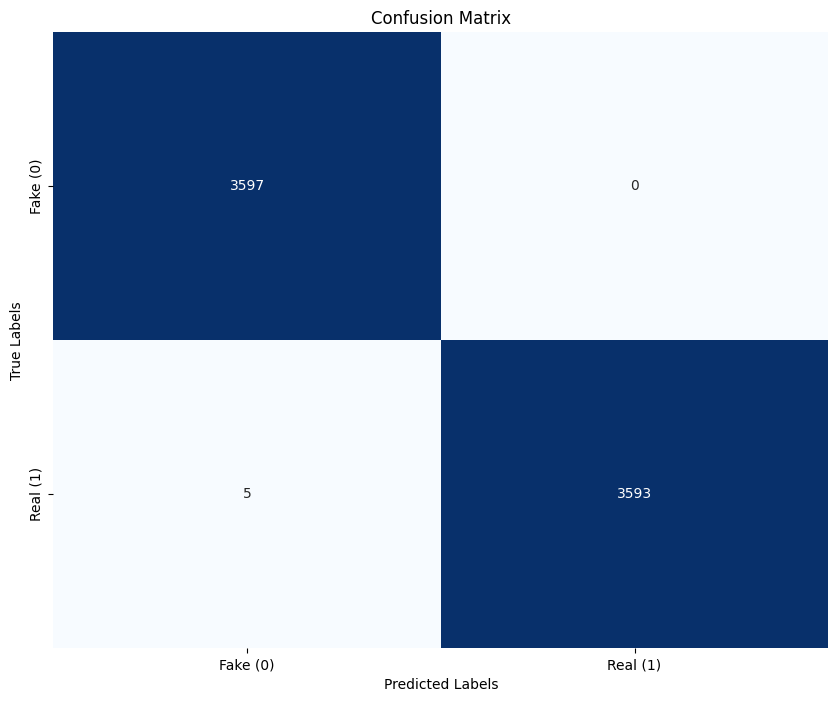

              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      3597
   Real News       1.00      1.00      1.00      3598

    accuracy                           1.00      7195
   macro avg       1.00      1.00      1.00      7195
weighted avg       1.00      1.00      1.00      7195



In [16]:
# Assuming you have a test set
visualize_best_model(best_model, X_val_seq, X_val_features, y_val)

In [17]:
# Print cross-validation results
print("\nCross-validation results:")
for result in fold_results:
    print(f"Fold {result['fold']}: Accuracy={result['val_accuracy']:.4f}, AUC={result['val_auc']:.4f}")

# Calculate average performance
avg_accuracy = np.mean([result['val_accuracy'] for result in fold_results])
avg_auc = np.mean([result['val_auc'] for result in fold_results])
print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
print(f"Average AUC: {avg_auc:.4f}")

# Save the best model, tokenizer, and vectorizers
best_model.save('best_fake_news_detection_model.keras')
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tfidf_vectorizer.pkl', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\nBest model, tokenizer, and vectorizers saved successfully!")



Cross-validation results:
Fold 1: Accuracy=0.9982, AUC=0.9992
Fold 2: Accuracy=0.9964, AUC=0.9989
Fold 3: Accuracy=0.9971, AUC=0.9987
Fold 4: Accuracy=0.9967, AUC=0.9980
Fold 5: Accuracy=0.9968, AUC=0.9986

Average Accuracy: 0.9970
Average AUC: 0.9987

Best model, tokenizer, and vectorizers saved successfully!


In [18]:
# Create inference function for testing on new data
def predict_fake_news(text, model, tokenizer, tfidf_vectorizer):
    # Clean and process text
    cleaned_text = clean_text(text)
    processed_text = tokenize_and_remove_stopwords(cleaned_text)

    # Extract features
    features = extract_features(cleaned_text)
    features_array = np.array([[
        features['sentiment_pos'],
        features['sentiment_neg'],
        features['sentiment_neu'],
        features['sentiment_compound'],
        features['readability'],
        features['grade_level'],
        features['word_count'],
        features['avg_word_length'],
        features['special_char_ratio']
    ]])

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([processed_text]).toarray()

    # Combine features
    combined_features = np.hstack((tfidf_features, features_array))

    # Predict
    prediction = model.predict([padded_sequence, combined_features])[0][0]
    label = "Real" if prediction >= 0.5 else "Fake"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    return {
        'label': label,
        'confidence': float(confidence),
        'raw_score': float(prediction)
    }

In [19]:

# Test function with sample text
sample_text = "Breaking: Scientists discover new renewable energy source that could revolutionize power generation"
prediction = predict_fake_news(sample_text, best_model, tokenizer, tfidf_vectorizer)
print(f"\nSample prediction: {prediction}")

print("\nModel is ready for inference on real-time data!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sample prediction: {'label': 'Fake', 'confidence': 0.9997768431494478, 'raw_score': 0.00022315685055218637}

Model is ready for inference on real-time data!
